<a href="https://colab.research.google.com/github/nabilaaaa24/Machine-Learning/blob/main/ML_Praktikum_Modul_4.3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
!pip install pandas scikit-learn

In [ ]:
!pip install wordcloud

# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/Prak ML/Demo/train.csv')
df

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


## EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [ ]:
label_counts = df['label'].value_counts()
label_counts

,count
label,
0,29720
1,2242


### Label Distribution

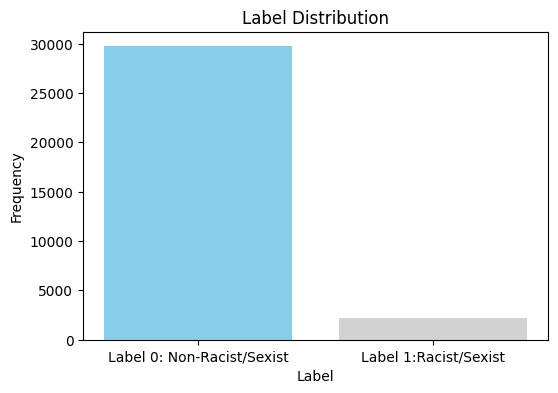

In [ ]:
# Tampilkan distribusi label menggunakan bar chart
plt.figure(figsize=(6, 4))
plt.bar(label_counts.index, label_counts.values, color=['skyblue', 'lightgrey'])
plt.xticks(ticks=[0, 1], labels=['Label 0: Non-Racist/Sexist', 'Label 1:Racist/Sexist'])
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Label Distribution')
plt.show()

### WordCloud

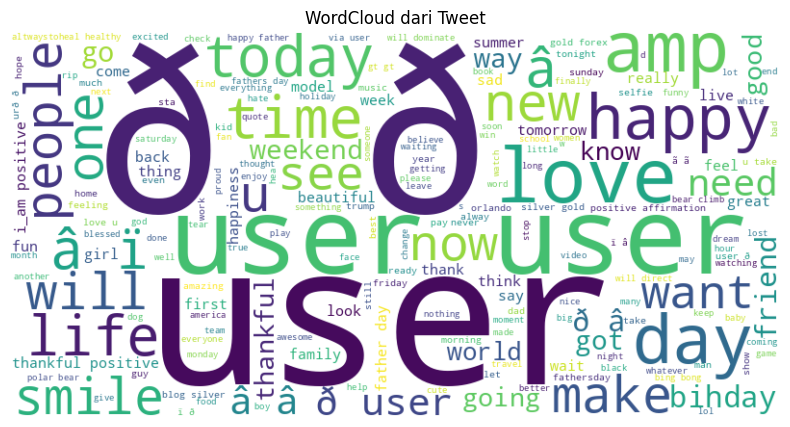

In [ ]:
from wordcloud import WordCloud
from collections import Counter

# Gabungkan semua teks tweet yang sudah dibersihkan
all_words = ' '.join([text for text in df['tweet']])

# Buat WordCloud
wordcloud = WordCloud(width=800, height=400, random_state=42, background_color='white', colormap='viridis').generate(all_words)

# Tampilkan WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud dari Tweet')
plt.show()


### 10 kata yang sering muncul

In [ ]:
# Tokenisasi semua kata
words = all_words.split()

# Hitung frekuensi kata
word_freq = Counter(words)

# Ambil 10 kata yang paling sering muncul
common_words = word_freq.most_common(10)

# Tampilkan kata-kata dan frekuensinya
print("10 Kata yang Paling Sering Muncul:")
for word, freq in common_words:
    print(f"{word}: {freq}")

10 Kata yang Paling Sering Muncul:
@user: 17291
the: 10065
to: 9768
a: 6261
i: 5655
you: 4949
and: 4831
in: 4570
for: 4435
of: 4152


# Data Augmentation

In [ ]:
import random

In [ ]:
# Fungsi untuk mendapatkan sinonim dari sebuah kata
def get_synonyms(word):
    synonyms = []
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.append(lemma.name())
    return list(set(synonyms))

In [ ]:
# Random Deletion
def random_deletion(words, p=0.1):
    if len(words) == 1:  # Jika teks hanya satu kata, tidak dihapus
        return words
    return [word for word in words if random.uniform(0, 1) > p]

In [ ]:
# Random Insertion
def random_insertion(words, n=1):
    for _ in range(n):
        synonyms = []
        word = random.choice(words)
        synonyms = get_synonyms(word)
        if synonyms:
            words.insert(random.randint(0, len(words)), random.choice(synonyms))
    return words

In [ ]:
# Random Synonym Replacement
def random_synonym_replacement(words, n=1):
    words = words.copy()
    for _ in range(n):
        idx = random.randint(0, len(words) - 1)
        synonyms = get_synonyms(words[idx])
        if synonyms:
            words[idx] = random.choice(synonyms)
    return words

In [ ]:
# Embedding Perturbation - add small random noise to word embeddings to increase model robustness
def add_embedding_noise(embedding_matrix, noise_factor=0.01):
    noise = np.random.normal(0, noise_factor, embedding_matrix.shape)
    return embedding_matrix + noise

In [ ]:
# Fungsi untuk menerapkan augmentasi pada teks
def augment_text(text, p_delete=0.05, n_swap=1, n_insert=1, n_synonym=1):
    words = text.split()
    words = random_deletion(words, p=p_delete)
    words = random_insertion(words, n=n_insert)
    words = random_synonym_replacement(words, n=n_synonym)
    return ' '.join(words)

# Preprocessing

In [ ]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

# Function to clean tweet text
def preprocess_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # remove URLs
    text = re.sub(r'@\w+', '', text)  # remove mentions
    text = re.sub(r'#\w+', '', text)  # remove hashtags
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    text = re.sub(r'[^\w\s]', '', text)  # remove emojis and non-ASCII characters
    text = text.lower()  # convert to lowercase
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stopwords])  # stemming and remove stopwords
    return text

# Apply preprocessing
df['cleaned_tweet'] = df['tweet'].apply(preprocess_text)

In [ ]:
df

,id,label,tweet,cleaned_tweet
0,1,0,@user when a father is dysfunctional and is s...,father dysfunct selfish drag kid dysfunct
1,2,0,@user @user thanks for #lyft credit i can't us...,thank credit use caus dont offer wheelchair va...
2,3,0,bihday your majesty,bihday majesti
3,4,0,#model i love u take with u all the time in ...,love u u time urð ðððð ððð
4,5,0,factsguide: society now #motivation,factsguid societi
...,...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...,ate isz youuuðððððððððâï
31958,31959,0,to see nina turner on the airwaves trying to...,nina turner airwav tri wrap mantl genuin hero ...
31959,31960,0,listening to sad songs on a monday morning otw...,listen sad song monday morn otw work sad
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,...",vandalis condemn act


## Tokenizing & Padding

In [ ]:
# Tokenization
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['cleaned_tweet'])
sequences = tokenizer.texts_to_sequences(df['cleaned_tweet'])

# Padding
max_length = 30  # define a maximum sequence length
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

## Train-Test Split

In [ ]:
X = padded_sequences
y = df['label']

# Split data into training and validation sets (80:20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build Model

In [ ]:
# Build LSTM model
model = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=max_length),
    LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)),  # L2 regularization
    Dropout(0.4),
    LSTM(32, return_sequences=True, kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    LSTM(16, kernel_regularizer=l2(0.001)),
    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Compile Model
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# Train Model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 58s 65ms/step - accuracy: 0.9244 - loss: 0.5631 - val_accuracy: 0.9287 - val_loss: 0.3666
Epoch 2/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 74s 56ms/step - accuracy: 0.9299 - loss: 0.3670 - val_accuracy: 0.9421 - val_loss: 0.2481
Epoch 3/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 88s 63ms/step - accuracy: 0.9477 - loss: 0.2340 - val_accuracy: 0.9465 - val_loss: 0.2307
Epoch 4/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 77s 57ms/step - accuracy: 0.9579 - loss: 0.1888 - val_accuracy: 0.9398 - val_loss: 0.2195
Epoch 5/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 45s 56ms/step - accuracy: 0.9628 - loss: 0.1696 - val_accuracy: 0.9443 - val_loss: 0.2149
Epoch 6/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 81s 56ms/step - accuracy: 0.9653 - loss: 0.1535 - val_accuracy: 0.9398 - val_loss: 0.2185
Epoch 7/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 83s 58ms/step - accuracy: 0.9703 - loss: 0.1347 - val_accuracy: 0.9302 - val_loss: 0.2189
Epoch 8/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 80s 55ms/step - accuracy: 0.9740 - loss: 0.1257 - 

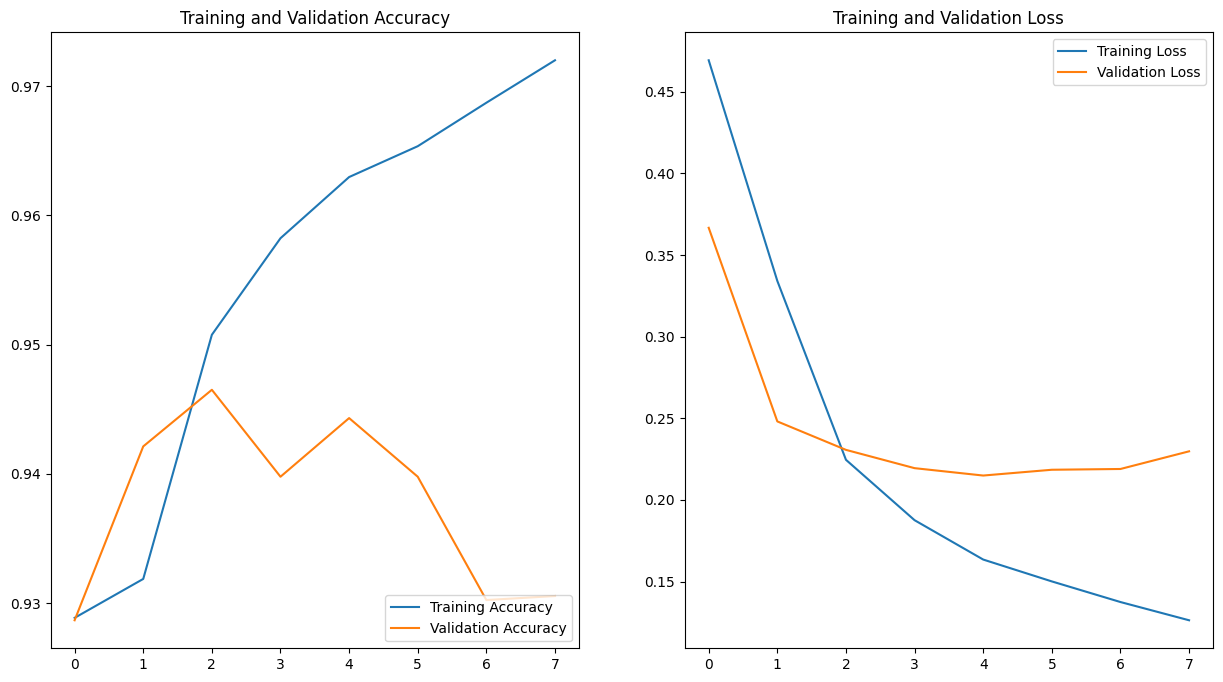

In [ ]:
plt.figure(figsize=(15, 8))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(len(history.history['accuracy'])), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(range(len(history.history['loss'])), history.history['loss'], label='Training Loss')
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
# Evaluasi Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9494 - loss: 0.1964
Accuracy: 94.43%


In [ ]:
# Membuat prediksi pada data uji
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step


In [ ]:
# Menampilkan classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5937
           1       0.66      0.45      0.53       456

    accuracy                           0.94      6393
   macro avg       0.81      0.71      0.75      6393
weighted avg       0.94      0.94      0.94      6393



# Prediksi Data Uji

In [ ]:
# Load dataset uji
test_df = pd.read_csv('/content/drive/MyDrive/Dataset/Prak ML/Demo/test.csv')

# Preprocess text pada dataset uji
test_df['cleaned_tweet'] = test_df['tweet'].apply(preprocess_text)

# Tokenisasi dan padding data uji
test_sequences = tokenizer.texts_to_sequences(test_df['cleaned_tweet'])
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post')

# Prediksi label pada dataset uji
y_test_pred_prob = model.predict(test_padded_sequences)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)  # konversi probabilitas ke biner (0 atau 1)

# Jika dataset uji memiliki kolom 'label', kita bisa langsung mengevaluasi
if 'label' in test_df.columns:
    y_test_true = test_df['label']

    # Menampilkan classification report
    print("\nClassification Report:")
    print(classification_report(y_test_true, y_test_pred))
else:
    print("Data uji tidak memiliki label, hanya menampilkan prediksi.")

# Jika Anda ingin menyimpan prediksi ke dalam file CSV
test_df['predicted_label'] = y_test_pred
test_df[['tweet', 'predicted_label']].to_csv('/content/drive/MyDrive/Dataset/Prak ML/test_predictions.csv', index=False)
print("\nPrediksi telah disimpan ke dalam 'test_predictions.csv'")

538/538 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step
Data uji tidak memiliki label, hanya menampilkan prediksi.

Prediksi telah disimpan ke dalam 'test_predictions.csv'


In [ ]:
test_df['predicted_label'].value_counts()

,count
predicted_label,
0,16346
1,851


In [ ]:
test_df

,id,tweet,cleaned_tweet,predicted_label
0,31963,#studiolife #aislife #requires #passion #dedic...,,0
1,31964,@user #white #supremacists want everyone to s...,want new â â hereâ,0
2,31965,safe ways to heal your #acne!! #altwaystohe...,safe way heal,0
3,31966,is the hp and the cursed child book up for res...,hp curs child book reserv ye ððð,0
4,31967,"3rd #bihday to my amazing, hilarious #nephew...",3rd amaz hilari eli ahmir uncl dave love missesâ,0
...,...,...,...,...
17192,49155,thought factory: left-right polarisation! #tru...,thought factori leftright polaris gt3,1
17193,49156,feeling like a mermaid ð #hairflip #neverre...,feel like mermaid ð â,0
17194,49157,#hillary #campaigned today in #ohio((omg)) &am...,today omg amp use word like assetsampli did sa...,0
17195,49158,"happy, at work conference: right mindset leads...",happi work confer right mindset lead cultureof...,0
